<a href="https://colab.research.google.com/github/h-razu/traffic_object_detection_bangladesh/blob/main/Traffic_Monitoring_Bangladesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the Environment

#### Import Required Library

In [1]:
import random
import shutil
import sys

import pandas as pd
import xml.etree.ElementTree as ET
from collections import Counter
from pathlib import Path

import yaml
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import cv2
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes, make_grid

#### Install and Import YOLO from ultralytics

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [3]:
import ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


#### Check the Version of Library

In [4]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("==============================")
print("matplotlib version:", plt.matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PyYAML version:", yaml.__version__)
print("PIL version : ", PIL.__version__)
print("CV2 version : ", cv2.__version__)
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("ultralytics version : ", ultralytics.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
matplotlib version: 3.10.0
pandas version: 2.2.2
PyYAML version: 6.0.2
PIL version :  11.2.1
CV2 version :  4.11.0
torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124
ultralytics version :  8.3.156


#### Check GPU Availability

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


#### Mounting Google Drive for Accessing Datasets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd '/content/drive/MyDrive/Colab Notebooks/datasets/'

/content/drive/MyDrive/Colab Notebooks/datasets


In [8]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (592 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [109]:
!tree dhaka_traffic_datasets --filelimit=10

dhaka_traffic_datasets
├── test dataset  [500 entries exceeds filelimit, not opening dir]
└── train dataset
    ├── annotations  [3003 entries exceeds filelimit, not opening dir]
    └── images  [3003 entries exceeds filelimit, not opening dir]

4 directories, 0 files


# DON'T RUN `EXPLORING THE DATA` AND `SEPARATE IMAGE AND ANNOTATION FILES`. BECAUSE FOLDER DOES NOT EXIST.

## Exploring the Data

In [10]:
dhaka_image_dir = Path("dhaka_traffic_datasets", "train dataset")
print(dhaka_image_dir)

dhaka_traffic_datasets/train dataset


In [11]:
dhaka_files = list(dhaka_image_dir.iterdir())
dhaka_files[-5:]

[PosixPath('dhaka_traffic_datasets/train dataset/10.xml'),
 PosixPath('dhaka_traffic_datasets/train dataset/06.jpeg'),
 PosixPath('dhaka_traffic_datasets/train dataset/05.jpg'),
 PosixPath('dhaka_traffic_datasets/train dataset/107.xml'),
 PosixPath('dhaka_traffic_datasets/train dataset/112.xml')]

Two types of files:

1. `.xml` files: These contain the annotations for the images.
2. `.jpg` files: These are the actual image files.

Each image typically has a corresponding XML file.

In [ ]:
dhaka_image = [f for f in dhaka_files if f.suffix != ".xml"][0]
print(dhaka_image)
Image.open(dhaka_image)

#### Read the corresponding Annotations file

In [38]:
xml_filepath = Path(dhaka_image_dir / f"{dhaka_image.stem}.xml")
!head -n 35 "$xml_filepath"

<annotation>
	<folder>data</folder>
	<filename>Pias (125).jpg</filename>
	<path>D:\Datasets\New\data\Pias (125).jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>854</width>
		<height>480</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>162</xmin>
			<ymin>280</ymin>
			<xmax>262</xmax>
			<ymax>350</ymax>
		</bndbox>
	</object>
	<object>
		<name>car</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>261</xmin>
			<ymin>290</ymin>
			<xmax>410</xmax>
			<ymax>409</ymax>


## Separate Image and Annotation Files

In [12]:
file_extension_counts = Counter(Path(file).suffix for file in dhaka_files)

for extension, count in file_extension_counts.items():
    print(f"Files with extension {extension}: {count}")

Files with extension .jpg: 2844
Files with extension .xml: 3003
Files with extension .PNG: 2
Files with extension .JPG: 143
Files with extension .png: 12
Files with extension .jpeg: 2


#### Create variables for the images and annotations directories

In [13]:
images_dir = Path(dhaka_image_dir) / "images"
annotations_dir = Path(dhaka_image_dir) / "annotations"

images_dir.mkdir(exist_ok=True)
annotations_dir.mkdir(exist_ok=True)

#### Move files to the appropriate directory based on file extensions

In [39]:
for file in dhaka_files:
    if file.suffix.lower() in (".jpg", ".jpeg", ".png"):
        target_dir = images_dir
    elif file.suffix.lower() == ".xml":
        target_dir = annotations_dir
    file.rename(target_dir / file.name)

#### Confirm that all the files where moved by making sure there is equal number of images and annotations.

In [40]:
images_files = list(images_dir.iterdir())
annotations_files = list(annotations_dir.iterdir())

assert len(images_files) == len(annotations_files)

## Draw Bounding Box with Label using Annotation File

In [110]:
random_image = random.choice([img for img in images_dir.glob("*")])
print(f'Image name: {random_image}')

img_name = Path(random_image.name)
annotation_file = annotations_dir / f"{img_name.stem}.xml"
print(f'Annotation file: {annotation_file}')

Image name: dhaka_traffic_datasets/train dataset/images/Numan_(138).jpg
Annotation file: dhaka_traffic_datasets/train dataset/annotations/Numan_(138).xml


#### Get each Label with Bounding Box from XML File

In [111]:
bounding_boxes = []
labels = []

tree = ET.parse(annotation_file)
root = tree.getroot()
width = int(root.find("size").find("width").text)
height = int(root.find("size").find("height").text)
print(f"image width: {width}  image height: {height}")
for obj in root.findall("object"):
    label = obj.find("name").text
    labels.append(label)
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    bounding_boxes.append([xmin, ymin, xmax, ymax])

for label, bounding_box in zip(labels, bounding_boxes):
    print(f"{label}: {bounding_box}")

image width: 640  image height: 360
rickshaw: [191, 85, 307, 342]
rickshaw: [313, 91, 516, 317]
rickshaw: [40, 75, 150, 227]
scooter: [158, 85, 190, 169]
pickup: [491, 83, 638, 234]


#### Convert bounding boxes to PyTorch tensors

In [112]:
bboxes_tensor = torch.tensor(bounding_boxes, dtype=torch.float)
print(bboxes_tensor)

tensor([[191.,  85., 307., 342.],
        [313.,  91., 516., 317.],
        [ 40.,  75., 150., 227.],
        [158.,  85., 190., 169.],
        [491.,  83., 638., 234.]])


#### Image with Bounding Box and Label

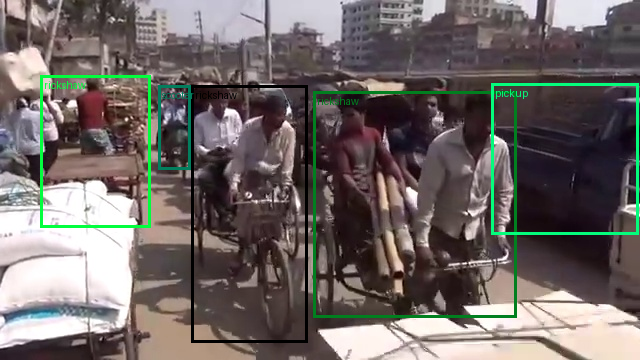

In [113]:
image = draw_bounding_boxes(
    image=read_image(str(random_image)),
    boxes=bboxes_tensor,
    labels=labels,
    width=3,
    fill=False,
)
to_pil_image(image)